In [1]:
# Step 1 - Mounting The Google Drive. User will need to give access to their Google drive for reading/writing data.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 2 - ensuring the needed backends are installed.

!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install basemap
!pip install h5py

In [ ]:
# Step 3 - Imporing the backends.

import numpy as np
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
from matplotlib.dates import DayLocator, HourLocator, DateFormatter
from matplotlib.colors import LogNorm
from mpl_toolkits.basemap import Basemap
from google.colab import files
import h5py

In [4]:
# Step 4 - Defining the prodedure to convert data from ICT standard files to python dictionaries.

#########################################################################################################################
# 
# Description: Procedure to open ICT file and format the data and headers into the output (output_dictionary) python 
# dictionary. Each of the required inputs for this code are described as follows:
# 1) filename: String or character containing the name of the desired ICT (*.ict) file.
#
# the output of this code is output_dictionary, which is a python3 dictionary containing column-arrays for each of the
# parameters in the *.ict file
# -> each column corresponds to a line in the provided *.ict file
#
#   EXAMPLES:
#       output_dictionary = importICT.imp("activate-mrg1_hu25_20200214_R0.ict")
#
#       print(output_dictionary)
#
#       output_dictionary =
#
#           {'Time_Start_seconds': array([61301., 61302., 61303., ..., 72258., 72259., 72260.]), 
#           'Time_Stop_seconds': array([61302., 61303., 61304., ..., 72259., 72260., 72261.]), 
#           'Latitude_THORNHILL_ deg': array([37.085528, 37.085798, 37.086065, ..., 37.126424, 37.126694, ...
#
#########################################################################################################################

def imp(filename = None): 
    G = open(filename, 'r') # open *.ict file
    g = G.readlines() # read *.ict file
    DATEinfo = np.array(g[6].split(",")) 
    DATE = DATEinfo[0:3] # save date to add to file

    Fv = g[11]  # locate line with fill values, wich are located on line 11 of .ict file, to replace with 'nan'
    fv = Fv.split(",") # create array of fill values
    varend = int(g[9]) # locate line with number of variables, which is located on line 9 of *.ict file

    full_var_titles = ["" for x in range(np.add(varend,1))] # create empty string array for full variable titles

    # fill full variable title string array with full variable titles starting on line 12 of *.ict file
    i2 = 12
    for i1 in range(varend):
        full_var_titles[np.add(i1,1)] = g[i2]
        i2 = np.add(i2,1)

    # fill first variable title string array position with full variable title of first variable on line 8 of *.ict file    
    starttime = g[8]
    full_var_titles[0] = starttime[0:len(starttime)-1]    

    # locate data header and data start rows of *.ict file using line 0 of *.ict file
    st = g[0]
    Vr_id = np.array(st.split(","))
    vr_id = np.add(int(Vr_id[0]),1)

    rawdata = g[vr_id::] # create raw data array starting at data start row

    # create empty string arrays for final variable names, units, and extra info
    var_names = ["" for x in range(len(full_var_titles))]
    var_units = ["" for x in range(len(full_var_titles))]
    
    # iteratively fill string arrays with final variable names, units, and extra info
    for i1 in np.arange(0,len(full_var_titles)).reshape(-1):
        fvt = full_var_titles[i1]
        FVT = fvt.split(",")
        var_names[i1] = FVT[0]
        var_units[i1] = FVT[1]

    # create data arraw with length of dataset and width of number of variables       
    data = np.zeros((len(rawdata),len(full_var_titles)))

    # iteratively fill data array with data and replace fv values with NAN
    for i1 in np.arange(0,len(rawdata)).reshape(-1):
        processdata1 = rawdata[i1]
        processdata2 = processdata1.split(",")
        for i2 in np.arange(0,len(processdata2)).reshape(-1):
            if processdata2[i2] == fv[np.add(i2,- 1)]:
                processdata2[i2] = 'nan'
            else:
                if float(processdata2[i2]) <= - 999.0:
                    processdata2[i2] = 'nan'
        data[i1,:] = processdata2
    
    # creat empty dictionary
    output_dictionary = {}

    # fill dictionary with data and keys   
    for i1 in range(len(full_var_titles)):
        output_dictionary[("%s_%s"%(var_names[i1],var_units[i1]))] = data[:,i1]

    output_dictionary["date"] = DATE # Add date to dictionary  
    start_time_array = data[:,0] # select start time
    end_time_array = data[:,1] # select end time
    mid_time_array = np.array(np.mean((start_time_array,end_time_array),axis=0))# create midtime array
    start_frmttimedata = ["" for x in range(len(start_time_array))] # create array of zeros for start datetime data
    start_mattimedata = np.zeros((len(start_time_array),6)) # create array of zeros for start datetime data
    end_frmttimedata = ["" for x in range(len(end_time_array))] # create array of zeros for end datetime data
    end_mattimedata = np.zeros((len(end_time_array),6)) # create array of zeros for end datetime data
    mid_frmttimedata = ["" for x in range(len(end_time_array))] # create array of zeros for mid datetime data
    mid_mattimedata = np.zeros((len(end_time_array),6)) # create array of zeros for mid datetime data
    # fill empty arrays formated datetime and matix date time
    for i1 in range(len(start_time_array)):   
        # convert DATE to separate integers
        Yr = int(DATE[0])
        Mon = int(DATE[1])
        Day = int(DATE[2])
                
        # convert seconds after mindnight to hour, minute, and second integers for start times
        Hr = int(np.floor(start_time_array[i1]/(60*60))) 
        Mnt = int(np.floor((start_time_array[i1]/(60*60)-np.floor(start_time_array[i1]/(60*60)))*60))
        Secd = int(((start_time_array[i1]/(60*60)-np.floor(start_time_array[i1]/(60*60)))*60-
          np.floor((start_time_array[i1]/(60*60)-np.floor(start_time_array[i1]/(60*60)))*60))*60)

        # set day to next dat if hours are greater than 23
        if Hr > 23:
            Hr = Hr - 24
            Day = Day + 1
        start_mattimedata[i1,:]  = [Yr,Mon,Day,Hr,Mnt,Secd] # store the matrix of year, month, day, hour, minute, second 
        start_frmttimedata[i1] = datetime.datetime(Yr,Mon,Day,Hr,Mnt,Secd) # store the formatted datetime

        # convert seconds after mindnight to hour, minute, and second integers for end times
        Hr = int(np.floor(end_time_array[i1]/(60*60))) 
        Mnt = int(np.floor((end_time_array[i1]/(60*60)-np.floor(end_time_array[i1]/(60*60)))*60))
        Secd = int(((end_time_array[i1]/(60*60)-np.floor(end_time_array[i1]/(60*60)))*60-
          np.floor((end_time_array[i1]/(60*60)-np.floor(end_time_array[i1]/(60*60)))*60))*60)

        # set day to next dat if hours are greater than 23
        if Hr > 23:
            Hr = Hr - 24
            Day = Day + 1    
        end_mattimedata[i1,:]  = [Yr,Mon,Day,Hr,Mnt,Secd] # store the matrix of year, month, day, hour, minute, second 
        end_frmttimedata[i1] = datetime.datetime(Yr,Mon,Day,Hr,Mnt,Secd) # store the formatted datetime

        # convert seconds after mindnight hour, minute, and second integers for start times
        Hr = int(np.floor(mid_time_array[i1]/(60*60))) 
        Mnt = int(np.floor((mid_time_array[i1]/(60*60)-np.floor(mid_time_array[i1]/(60*60)))*60))
        Secd = int(((mid_time_array[i1]/(60*60)-np.floor(mid_time_array[i1]/(60*60)))*60-
          np.floor((mid_time_array[i1]/(60*60)-np.floor(mid_time_array[i1]/(60*60)))*60))*60)

        # set day to next dat if hours are greater than 23
        if Hr > 23:
            Hr = Hr - 24
            Day = Day + 1
        mid_mattimedata[i1,:]  = [Yr,Mon,Day,Hr,Mnt,Secd] # store the matrix of year, month, day, hour, minute, second 
        mid_frmttimedata[i1] = datetime.datetime(Yr,Mon,Day,Hr,Mnt,Secd) # store the formatted datetime

    # Add start, mid, and end frmttimedata and mattimedata to dictionary   
    output_dictionary["start_fmtdatetime"] = start_frmttimedata
    output_dictionary["start_mattimedata"] = start_mattimedata
    output_dictionary["mid_fmtdatetime"] = mid_frmttimedata
    output_dictionary["mid_matdatetime"] = mid_mattimedata    
    output_dictionary["end_fmtdatetime"] = end_frmttimedata
    output_dictionary["end_matdatetime"] = end_mattimedata
    G.close() # close data file      
    return output_dictionary
    ##
    return output_dictionary

In [5]:
# Step 5 - Running the ICT conversion procedured defined in Step 4 to get the 60s in-situ data and the leg index files for
# a case study research flight. Displaying all of the parameters that avarailable in each newly created dictionary

#########################################################################################################################
#
# Description: procedure for converting the data and leg index files from their *.ict format to a python 
# dictionary and displaying all parameters that are in the newly created dictionary.
# 
#########################################################################################################################

colab_path = "/content/drive/MyDrive/Colab_Notebooks/" # colab directory

data_filename = "activate-mrg1_hu25_20200828_R0.ict" # data filename
LegIndex_filename = "ACTIVATE-LegFlags_HU25_20200828_R0.ict" # data filename

data_pathfilename = "%s%s"%(colab_path,data_filename) # data path and filename
LegIndex_pathfilename = "%s%s"%(colab_path,LegIndex_filename) # leg index path and filename

# convert the *.ict files into python dictionaries
data_dictionary = imp(data_pathfilename)
LegID_dictionary = imp(LegIndex_pathfilename)

# display the avalable parameters from each dictionary
for key in data_dictionary.items():
    print(key[0])
print("")    
for key in LegID_dictionary.items():
    print(key[0])

Time_Start_ seconds
Time_Stop_ seconds
Latitude_THORNHILL_  deg
Longitude_THORNHILL_  deg
GPS_Altitude_THORNHILL_  m
Pressure_Altitude_THORNHILL_  ft
Pitch_THORNHILL_  deg +-180
Roll_THORNHILL_  deg +-180
True_Heading_THORNHILL_  deg 0-360
True_Air_Speed_THORNHILL_  m/s
Static_Air_Temp_THORNHILL_  degrees Celcius
Dew_Point_THORNHILL_  degrees Celcius
IR_Surf_Temp_THORNHILL_  degrees Celcius
Static_Pressure_THORNHILL_  mb
Wind_Speed_THORNHILL_  m/s
Wind_Direction_THORNHILL_  deg 0-360 cw from +y
WSPD_ms-1_THORNHILL_  ms-1
WDIR_deg_THORNHILL_  deg
U_ms-1_THORNHILL_  ms-1
V_ms-1_THORNHILL_  ms-1
w_ms-1_THORNHILL_  ms-1
H2O_DLH_DISKIN_  ppmv
RHi_DLH_DISKIN_  percent
RHw_DLH_DISKIN_  percent
CH4_ppm_DISKIN_  ppm
CO_ppm_DISKIN_  ppm
CO2_ppm_DISKIN_  ppm
O3_ppbv_DISKIN_  ppbv
N_CAS_MOORE_  #/cm3
LWC_CAS_MOORE_  g/m3
Reff_CAS_MOORE_  micron
Veff_CAS_MOORE_  micron
CAS_Bin00_MOORE_  #/cm3
CAS_Bin01_MOORE_  #/cm3
CAS_Bin02_MOORE_  #/cm3
CAS_Bin03_MOORE_  #/cm3
CAS_Bin04_MOORE_  #/cm3
CAS_Bin05_M

In [6]:
# Step 6 - Retrieving the standard acronmym identifiers from the provided LegTypes.csv file and adding the leg types to
# the dictonary containing the leg inedx information. The LegTypes.csv file comes from line 30 of the *.ict LegIndex file 

#########################################################################################################################
#
# Description: procedure for converting the numeric leg indicies to acronym identifiers
# 
#########################################################################################################################

# generate arrays for numeric leg indicies 
LegIndex = np.array([value for key, value in LegID_dictionary.items() if key.startswith("LegIndex")],dtype=int) 
LegIndex = LegIndex[0]

# read LegTypes.csv to match leg the leg index to the leg type (see line)
legtype = np.array(pd.read_csv ("%sLegTypes.csv"%colab_path))

# create empty string array to store leg types and loop through LegIndex file and assign types
LegType = ["" for x in range(len(LegIndex))] 
for i1 in range(len(LegIndex)):
  a = int(str(LegIndex[i1])[7:9])
  idx = np.array(np.where(legtype[:,0]==a))
  LegType[i1] = legtype[idx,1]

# store the leg type array to the leg index dictionary
LegID_dictionary["LegType"] = LegType

[130.88  68.68 107.61 ... 153.79 224.14 184.64]


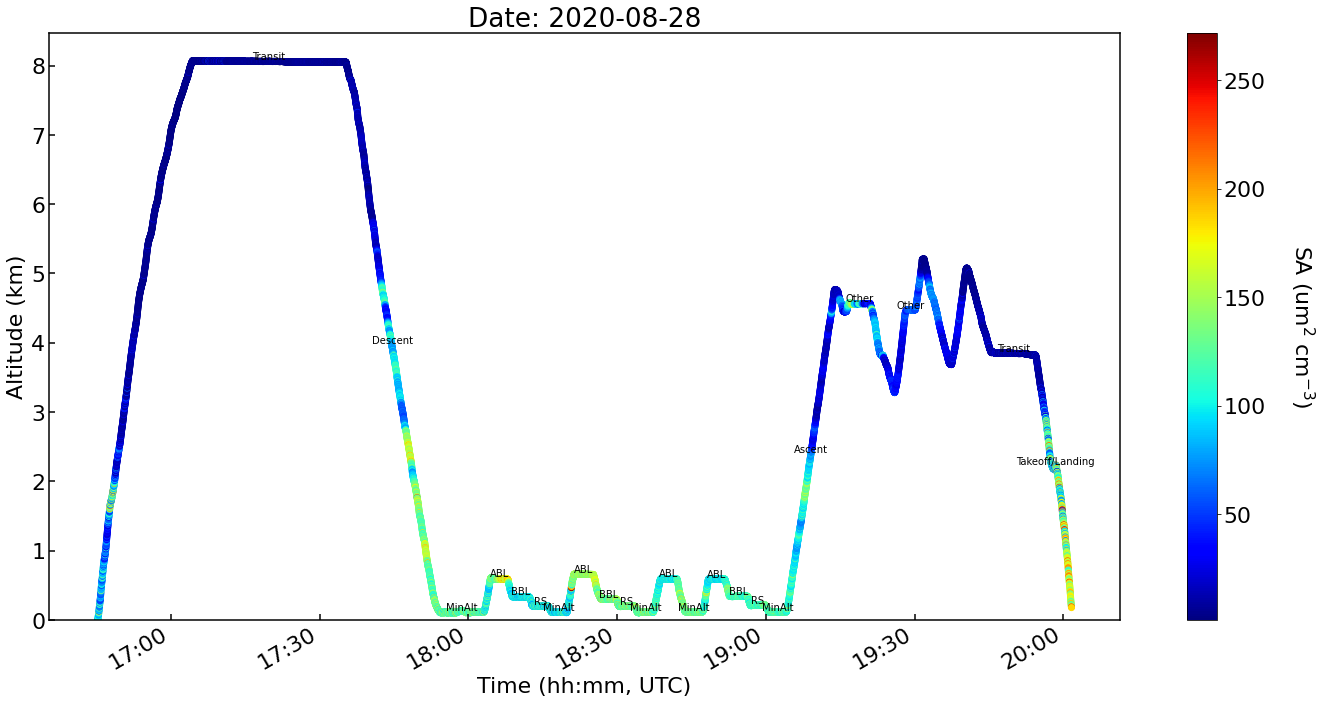

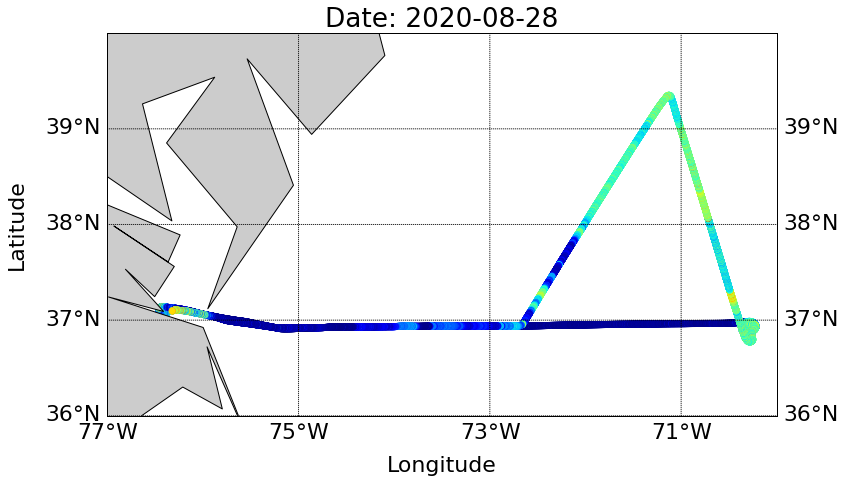

In [7]:
# Step 7 - Gerating basic in-situ research flight track and aircraft altitude time series.

#########################################################################################################################
#
# Description: procedure for plotting a flight track and time series of measured altitude colored by aerosol particle 
# surface area concentration (SA) annotated with the leg identifiers.
#
#########################################################################################################################

# generate arrays for latitude, longitude, altitude, formatted time, aerosol particle surface area concentration, and  
# date from the data dictionary
latitude_data = np.array([value for key, value in data_dictionary.items() if key.startswith("Latitude")])[0]
longitude_data = np.array([value for key, value in data_dictionary.items() if key.startswith("Longitude")])[0]
altitude_data = np.array([value for key, value in data_dictionary.items() if key.startswith("GPS_Altitude")])[0]
time_data = np.array([value for key, value in data_dictionary.items() if key.startswith("mid_fmtdatetime")])[0]
SA_data = np.array([value for key, value in data_dictionary.items() if key.startswith("IntegS_Dopt90to7500nm")])[0]
print(SA_data)
SA_data[np.isnan(SA_data)] = 0
date = np.array([value for key, value in data_dictionary.items() if key.startswith("date")])[0]

# generate arrays for the leg types and the formatted start, midpoint, and end times of each leg
LegTypes = np.array([value for key, value in LegID_dictionary.items() if key.startswith("LegType")])[0]
LegTypes_starttime = np.array([value for key, value in LegID_dictionary.items() if key.startswith("start_fmtdatetime")])[0] 
LegTypes_midtime = np.array([value for key, value in LegID_dictionary.items() if key.startswith("mid_fmtdatetime")])[0]
LegTypes_endtime = np.array([value for key, value in LegID_dictionary.items() if key.startswith("end_fmtdatetime")])[0]

plt.rcParams.update({'font.size': 22}) # set default font size for this and subsequent figures 0
fig,ax1=plt.subplots(1, 1,figsize=(24,12)) # create figure and subplot
#ax1.plot(time_data, altitude_data/1000,'-ro',lw=2) # plotting time versus aircraft altitude, in km  
sc = ax1.scatter(time_data, altitude_data/1000,c=SA_data, cmap='jet')
cbar = fig.colorbar(sc, ax=ax1)
cbar.ax.get_yaxis().labelpad = 50
cbar.set_label(r'SA (um$^{2}$ cm$^{-3}$)', rotation=270)

# loop through all legs indicies and annotate the time series with the leg type 
# as defined by the last two digits of the leg index
for i1 in range(len(LegTypes)):
  idx = np.array(np.where((time_data>=LegTypes_starttime[i1])&(time_data<=LegTypes_endtime[i1])))[0]
  leg_altitude = np.nanmean(altitude_data[idx])
  LegType_text = "%s"%LegTypes[i1,0,0]
  t = ax1.text(LegTypes_midtime[i1], leg_altitude/1000,LegType_text,
               horizontalalignment ='center',verticalalignment ='bottom',fontsize = 10)

# format axis
ax1.set_ylim(0,None) # cut y-axis off at zero
# set the line widths of the axes
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(1.5)
ax1.tick_params(direction='in', length=6, width=1.5) # set inside facing ticks, ticklength, and tick line width
ax1.xaxis.set_major_formatter(DateFormatter('%H:%M'))  # set xaxis major lines datetime format
ax1.fmt_xdata = DateFormatter('%H:%M') # set xaxis datetime format
ax1.set_xlabel("Time (hh:mm, UTC)") # set xaxis label 
ax1.set_ylabel("Altitude (km)") # set yaxis label 
plt.gcf().autofmt_xdate() # autoformat datetimes to look better

ax1.set_title("Date: %s-%s-%s"%(date[0],date[1],date[2])) #set title as flight date.

# display and save figure using the *.ict data filename 
plt.savefig("%saltitude_SA_timeseries_%s-%s-%s"%(colab_path,date[0],date[1],date[2]), dpi=300)
plt.show() # function to display the plot

print("") # blank space for separation

# create figure a geographical map for plotting flight tracks
ax2=plt.subplots(1, 1,figsize=(12,12))

# use Basemap function to display map of the research flight's study region and format
m = Basemap(projection='cyl',llcrnrlat=np.floor(np.nanmin(latitude_data)),urcrnrlat=np.ceil(np.nanmax(latitude_data)),\
            llcrnrlon=np.floor(np.nanmin(longitude_data)),urcrnrlon=np.ceil(np.nanmax(longitude_data)),resolution='c')
m.drawcoastlines() # diplay coastlines 
m.fillcontinents() # fill continents with grey 

# plot the flight track in latitude and longitude coordinates
#x,y = m(longitude_data,latitude_data)
#m.plot(x,y, '-ro')
# plot the flight track in latitude and longitude coordinates
x,y = m(longitude_data,latitude_data)
m.scatter(x,y,c=SA_data, cmap='jet')
cbar = fig.colorbar(sc, ax=ax1)
cbar.ax.get_yaxis().labelpad = 50
cbar.set_label(r'SA (um$^{2}$ cm$^{-3}$)', rotation=270)

# draw parallels and meridians
m.drawparallels(np.arange(np.floor(np.nanmin(latitude_data)),np.ceil(np.nanmax(latitude_data)),1),labels=[1,1,0,1])
m.drawmeridians(np.arange(np.floor(np.nanmin(longitude_data)),np.ceil(np.nanmax(longitude_data)),2),labels=[1,1,0,1])

m.drawmapboundary(fill_color='#FFFFFF') # draw box around plot

# format axes
plt.xlabel('Longitude', labelpad=40)
plt.ylabel('Latitude', labelpad=80)

plt.title("Date: %s-%s-%s"%(date[0],date[1],date[2])) #set title as flight date.
plt.savefig("%sSA_flight_track_%s-%s-%s"%(colab_path,date[0],date[1],date[2]), dpi=300)
plt.show() # function to show the plot



In [8]:
# Step 8 - Reading the HSRL and RSP data into python dictionaries.

#########################################################################################################################
#
# Description: procedure for reading the HSRL-2 and RSP data files from their *.h5 format into a python dictionary and 
# displaying all parameters that are in the newly created dictionary.
# 
#########################################################################################################################

# read the RSP data and display all avalable data products
RSP_dictionary = h5py.File("%sRSP-MAPP-AAO-archive-v1.48-activate-daily-activate-20200828.h5"%colab_path, "r")
print("RSP data products:")
print(RSP_dictionary.keys())

# take the flight date from the RSP readme line 9
RSP_Date = [str(RSP_dictionary["000-README"][9])[24:28],str(RSP_dictionary["000-README"][9])[28:30],str(RSP_dictionary["000-README"][9])[30:32]]

rsp_time_array = np.array(RSP_dictionary["time"]) # select rsp time
rsp_frmttimedata = ["" for x in range(len(rsp_time_array))] # create array of zeros for rsp datetime data
rsp_mattimedata = np.zeros((len(rsp_time_array),6)) # create array of zeros for start datetime data
# fill empty arrays formated datetime and matix date time
for i1 in range(len(rsp_time_array)):   
    # convert DATE to separate integers
    Yr = int(RSP_Date[0])
    Mon = int(RSP_Date[1])
    Day = int(RSP_Date[2])
                
    # fractional hours after midnight to hour, minute, and second integers for rsp times
    Hr = int(np.floor(rsp_time_array[i1])) 
    Mnt = int(np.floor((rsp_time_array[i1]-np.floor(rsp_time_array[i1]))*60))
    Secd = int(((rsp_time_array[i1]-np.floor(rsp_time_array[i1]))*60-
    np.floor((rsp_time_array[i1]-np.floor(rsp_time_array[i1]))*60))*60)

    # set day to next dat if hours are greater than 23
    if Hr > 23:
        Hr = Hr - 24
        Day = Day + 1

    rsp_mattimedata[i1,:]  = [Yr,Mon,Day,Hr,Mnt,Secd] # store the matrix of year, month, day, hour, minute, second 
    rsp_frmttimedata[i1] = datetime.datetime(Yr,Mon,Day,Hr,Mnt,Secd) # store the formatted datetime

# read the HSRL-2 data and display all groups and avalable data products
HSRL2_dictionary = h5py.File("%sACTIVATE-HSRL2_UC12_20200828_RB.h5"%colab_path, "r")
print("HSRL-2 metadata:")
print(HSRL2_dictionary.keys())
print("HSRL-2 data products:")
print(HSRL2_dictionary["DataProducts"].keys())
print("HSRL-2 navigation and time data:")
print(HSRL2_dictionary["Nav_Data"].keys())

# take the flight date from the HSRL readme line 4
HSRL2_Date = [str(HSRL2_dictionary['000_Readme'][4])[2:6],str(HSRL2_dictionary['000_Readme'][4])[7:9],str(HSRL2_dictionary['000_Readme'][4])[10:12]]

hsrl2_time_array = np.array(HSRL2_dictionary["Nav_Data"]["gps_time"])# select hsrl-2 time
hsrl2_frmttimedata = ["" for x in range(len(hsrl2_time_array))] # create array of zeros for hsrl-2 datetime data
hsrl2_mattimedata = np.zeros((len(hsrl2_time_array),6)) # create array of zeros for start datetime data

# fill empty arrays formated datetime and matix date time
for i1 in range(len(hsrl2_time_array)):   
    # convert DATE to separate integers
    Yr = int(HSRL2_Date[0])
    Mon = int(HSRL2_Date[1])
    Day = int(HSRL2_Date[2])
                
    # convert fractional hours after midnight to hour, minute, and second integers for hsrl-2 times
    Hr = int(np.floor(hsrl2_time_array[i1])) 
    Mnt = int(np.floor((hsrl2_time_array[i1]-np.floor(hsrl2_time_array[i1]))*60))
    Secd = int(((hsrl2_time_array[i1]-np.floor(hsrl2_time_array[i1]))*60-
    np.floor((hsrl2_time_array[i1]-np.floor(hsrl2_time_array[i1]))*60))*60)

    # set day to next dat if hours are greater than 23
    if Hr > 23:
        Hr = Hr - 24
        Day = Day + 1

    hsrl2_mattimedata[i1,:]  = [Yr,Mon,Day,Hr,Mnt,Secd] # store the matrix of year, month, day, hour, minute, second 
    hsrl2_frmttimedata[i1] = datetime.datetime(Yr,Mon,Day,Hr,Mnt,Secd) # store the formatted datetime


RSP data products:
<KeysViewHDF5 ['000-README', 'Date', 'Serr_diag', 'Serr_total', 'Serr_total_diag', 'aerosol_N_c', 'aerosol_N_f', 'aerosol_S_c', 'aerosol_S_f', 'aerosol_V_c', 'aerosol_V_f', 'aerosol_imag_c_555', 'aerosol_imag_f_555', 'aerosol_kext_c', 'aerosol_kext_f', 'aerosol_p180_c', 'aerosol_p180_f', 'aerosol_real_c_555', 'aerosol_real_f_555', 'aerosol_reff_c', 'aerosol_reff_f', 'aerosol_reff_total', 'aerosol_ssa_c', 'aerosol_ssa_c_555', 'aerosol_ssa_f', 'aerosol_ssa_f_555', 'aerosol_ssa_total_555', 'aerosol_tau_c', 'aerosol_tau_c_555', 'aerosol_tau_f', 'aerosol_tau_f_555', 'aerosol_tau_total_555', 'aerosol_top_height', 'aerosol_veff_c', 'aerosol_veff_f', 'aircraft_altitude', 'aircraft_lat', 'aircraft_lon', 'aircraft_pitch', 'aircraft_roll', 'aircraft_yaw', 'atmos_water_vapor_column_amount', 'cloud_top_height', 'lat', 'lon', 'output_channels', 'retrieval_normalized_cost_function_data', 'retrieval_normalized_cost_function_total', 'rsp_relative_azimuth', 'rsp_solar_zenith', 'rsp_ti

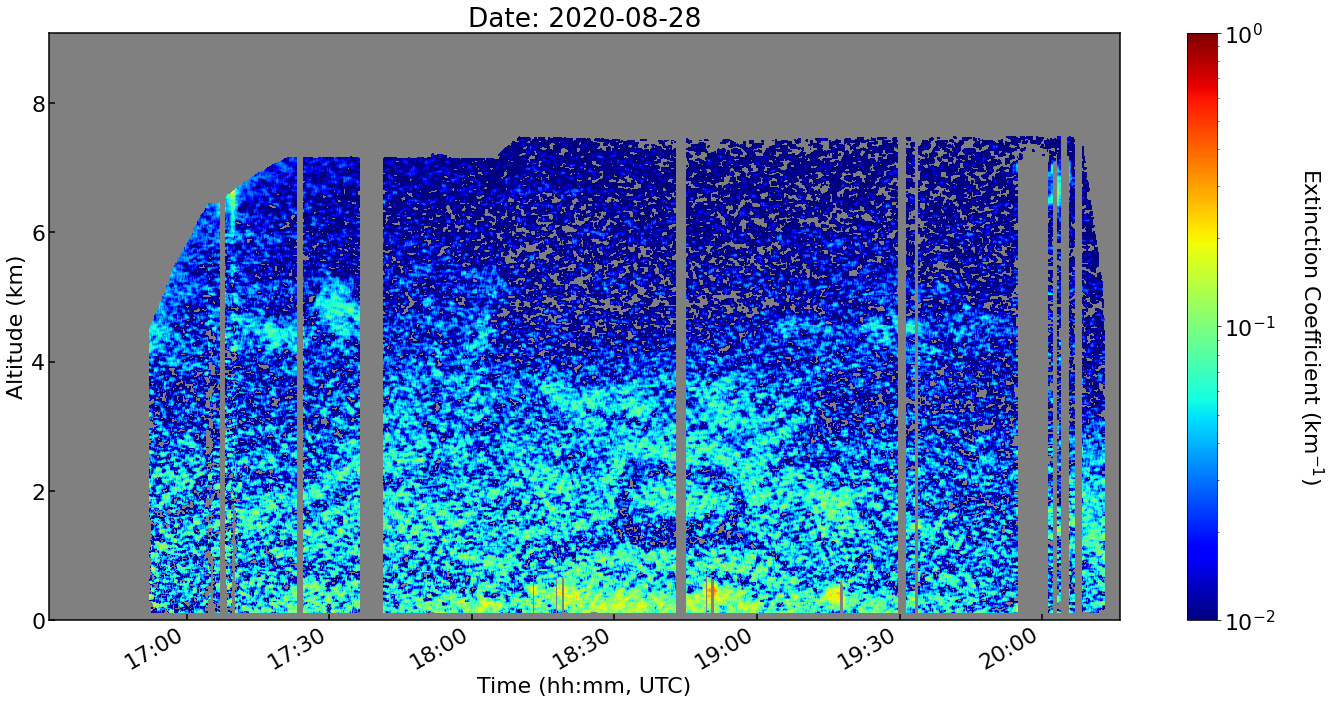

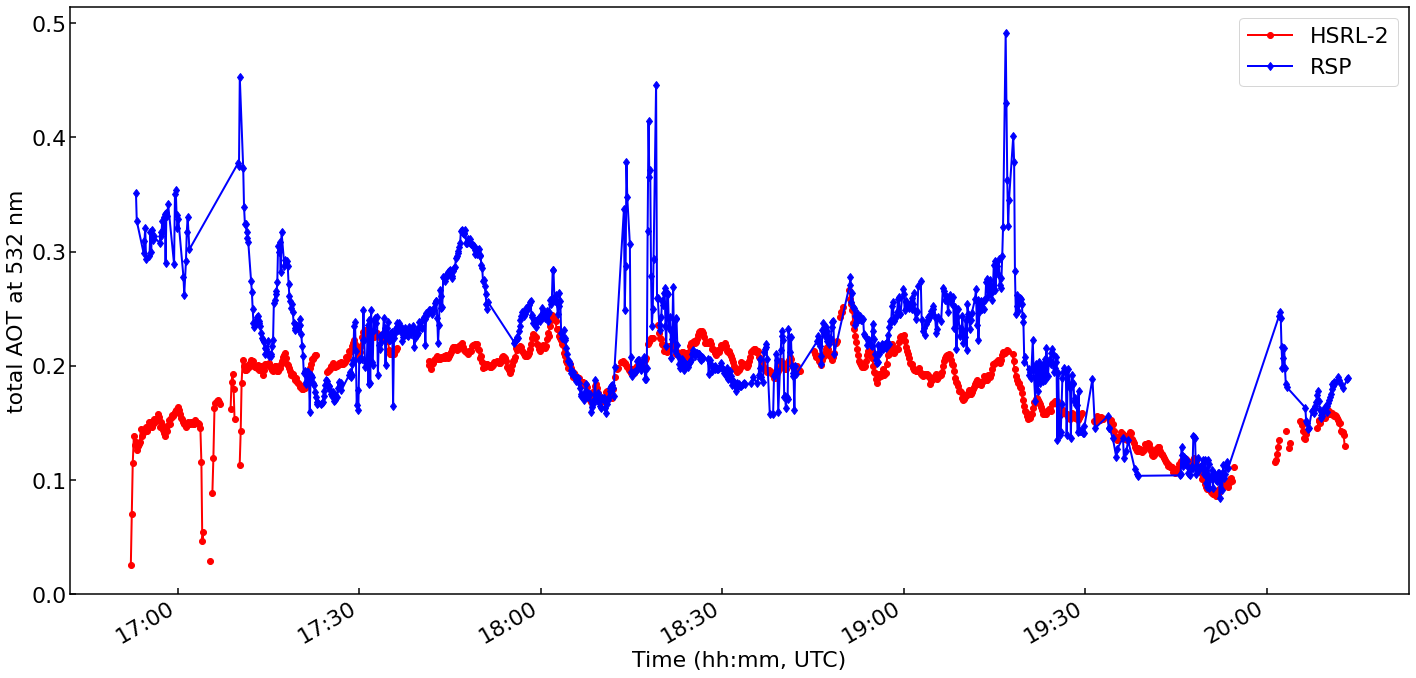

In [9]:
# Step 9 - Generating HSRL-2 particle exctinction coefficient curtain time series and time series of HSRL-2 and RSP total  
# aerosol optical thickness (AOT). 

#########################################################################################################################
#
# Description: procedure for plotting HSRL-2 aerosol particle exctinction coefficient curtain time series and time series 
# of HSRL-2 and RSP total AOT measured at 532 nm wavelngths.
#
#########################################################################################################################

# generate arrays for the HSRL-2 altitude grid and aerosol particle exctinction coefficient HSRL-2 dictionary
hsrl2_altitudegrid_data = np.array(HSRL2_dictionary["DataProducts"]["Altitude"])[0] # m
hsrl2_extinction_data = np.array(HSRL2_dictionary["DataProducts"]["532_ext"]) # km-1

# generate arrays for the HSRL-2 and RSP 532 nm total AOT
hsrl2_aot_data = np.array(HSRL2_dictionary["DataProducts"]["532_AOT_hi"])
rsp_aot_data = np.add(np.array(RSP_dictionary["aerosol_tau_c"])[:,8],np.array(RSP_dictionary["aerosol_tau_f"])[:,8])

fig,ax1=plt.subplots(1, 1,figsize=(24,12)) # create figure and subplot
ax1.set_facecolor('gray')

# plotting a color plot of exctinction coefficient, in km-1 with time versus aircraft altitude, in km  
Z = hsrl2_extinction_data
X = hsrl2_frmttimedata
Y = hsrl2_altitudegrid_data/1000
c = ax1.pcolor(X, Y, Z.T, cmap='jet', norm=LogNorm(vmin=0.01, vmax=1))
cbar = fig.colorbar(c, ax=ax1)
cbar.ax.get_yaxis().labelpad = 50
cbar.set_label(r'Extinction Coefficient (km$^{-1}$)', rotation=270)

# format axis
ax1.set_ylim(0,None) # cut y-axis off at zero
# set the line widths of the axes
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(1.5)
ax1.tick_params(direction='in', length=6, width=1.5) # set inside facing ticks, ticklength, and tick line width
ax1.xaxis.set_major_formatter(DateFormatter('%H:%M'))  # set xaxis major lines datetime format
ax1.fmt_xdata = DateFormatter('%H:%M') # set xaxis datetime format
ax1.set_xlabel("Time (hh:mm, UTC)") # set xaxis label 
ax1.set_ylabel("Altitude (km)") # set yaxis label 
plt.gcf().autofmt_xdate() # autoformat datetimes to look better

ax1.set_title("Date: %s-%s-%s"%(HSRL2_Date[0],HSRL2_Date[1],HSRL2_Date[2])) #set title as flight date.

# display and save figure using the *.ict data filename 
plt.savefig("%sHSRL-2_532nmAerosolExtCoef_pcolortimeseries_%s-%s-%s"%(colab_path,HSRL2_Date[0],HSRL2_Date[1],HSRL2_Date[2]), dpi=300)
plt.show() # function to display the plot

print("") # blank space for separation

fig,ax2=plt.subplots(1, 1,figsize=(24,12)) # create figure and subplot
ax2.plot(hsrl2_frmttimedata, hsrl2_aot_data,'-ro',lw=2,label='HSRL-2') # plotting hsrl-2 time versus 532 nm AOT
ax2.plot(rsp_frmttimedata, rsp_aot_data,'-bd',lw=2,label='RSP') # plotting rsp time versus 532 nm AOT

ax2.legend(); # add legend
ax2.set_ylim(0,None) # cut y-axis off at zero

# set the line widths of the axes
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(1.5)

ax2.tick_params(direction='in', length=6, width=1.5) # set inside facing ticks, ticklength, and tick line width
ax2.xaxis.set_major_formatter(DateFormatter('%H:%M'))  # set xaxis major lines datetime format
ax2.fmt_xdata = DateFormatter('%H:%M') # set xaxis datetime format
ax2.set_xlabel("Time (hh:mm, UTC)") # set xaxis label 
ax2.set_ylabel("total AOT at 532 nm") # set yaxis label 
plt.gcf().autofmt_xdate() # autoformat datetimes to look better

ax1.set_title("Date: %s-%s-%s"%(date[0],date[1],date[2])) #set title as flight date.

# display and save figure using the *.ict data filename 
plt.savefig("%sHSRL-2&RSP_532nmAOT_timeseries_%s-%s-%s"%(colab_path,HSRL2_Date[0],HSRL2_Date[1],HSRL2_Date[2]), dpi=300)
plt.show() # function to display the plot

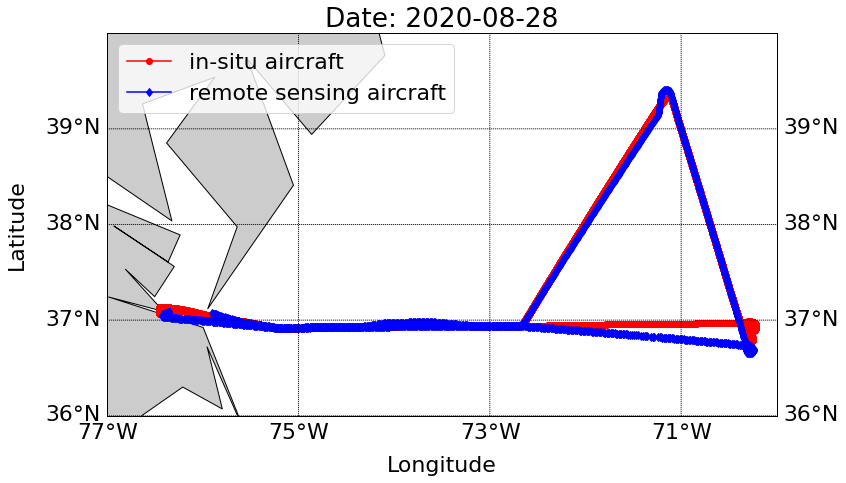

In [10]:
# Step 10 - Generating remote sensing and in-situ aircraft flight track overlays

#########################################################################################################################
#
# Description: procedure for plotting a flight tracks of both remote sensing and in-situ aircraft
#
#########################################################################################################################

# generate arrays for the HSRL-2 latitude and longitude
hsrl2_latitude_data = np.array(HSRL2_dictionary["Nav_Data"]["gps_lat"])
hsrl2_longitude_data = np.array(HSRL2_dictionary["Nav_Data"]["gps_lon"])

# create figure a geographical map for plotting flight tracks
ax2=plt.subplots(1, 1,figsize=(12,12))

# use Basemap function to display map of the research flight's study region and format
m = Basemap(projection='cyl',llcrnrlat=np.floor(np.nanmin(latitude_data)),urcrnrlat=np.ceil(np.nanmax(latitude_data)),\
            llcrnrlon=np.floor(np.nanmin(longitude_data)),urcrnrlon=np.ceil(np.nanmax(longitude_data)),resolution='c')
m.drawcoastlines() # diplay coastlines 
m.fillcontinents() # fill continents with grey 

# plot the flight track in latitude and longitude coordinates
x,y = m(longitude_data,latitude_data)
m.plot(x,y,'-ro',label='in-situ aircraft')
x1,y1 = m(hsrl2_longitude_data,hsrl2_latitude_data)
m.plot(x1,y1,'-bd',label='remote sensing aircraft')
plt.legend(); # add legend

# draw parallels and meridians
m.drawparallels(np.arange(np.floor(np.nanmin(latitude_data)),np.ceil(np.nanmax(latitude_data)),1),labels=[1,1,0,1])
m.drawmeridians(np.arange(np.floor(np.nanmin(longitude_data)),np.ceil(np.nanmax(longitude_data)),2),labels=[1,1,0,1])

m.drawmapboundary(fill_color='#FFFFFF') # draw box around plot

# format axes
plt.xlabel('Longitude', labelpad=40)
plt.ylabel('Latitude', labelpad=80)

plt.title("Date: %s-%s-%s"%(date[0],date[1],date[2])) #set title as flight date.
plt.savefig("%sflight_tracks_%s-%s-%s"%(colab_path,date[0],date[1],date[2]), dpi=300)
plt.show() # function to show the plot